In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import anndata as ad
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
import os.path
import harmonypy as hm

import celltypist
from celltypist import models

import muon as mu
from muon import MuData

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

### Ingest

In [3]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/download_object/PAN.A01.v01.raw_count.20210429.NKT.embedding.h5ad'
adata_ref = sc.read_h5ad(input_file)

In [4]:
adata_ref

AnnData object with n_obs × n_vars = 174261 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [5]:
adata_ref = adata_ref[~adata_ref.obs['celltype_annotation'].isin(['DOUBLET','DOUBLET_ERY_B',
                                                                 'HIGH_MITO','LOW_Q_INCONSISTENT','nan'])].copy()

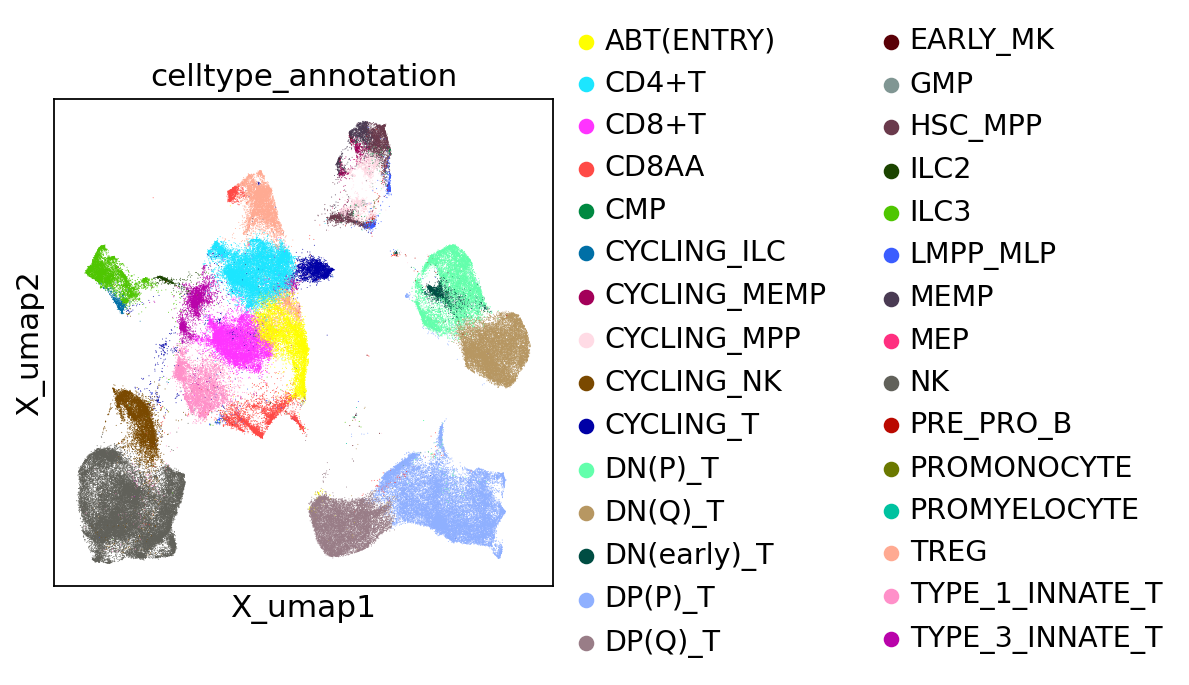

In [6]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.embedding(adata_ref, basis = 'X_umap', color=['celltype_annotation'])

In [7]:
adata_ref.X.expm1().sum(axis = 1)

matrix([[          inf],
        [          inf],
        [          inf],
        ...,
        [          inf],
        [          inf],
        [1.5061224e+35]], dtype=float32)

In [8]:
sc.pp.normalize_per_cell(adata_ref, counts_per_cell_after = 1e4)
sc.pp.log1p(adata_ref)

normalizing by total count per cell
    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [9]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Malignant_Tcell_final_initial.h5ad'
adata = sc.read_h5ad(input_file)

In [10]:
adata.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.   ],
        [ 9999.999],
        ...,
        [10000.   ],
        [10000.001],
        [10000.002]], dtype=float32)

In [11]:
adata

AnnData object with n_obs × n_vars = 87263 × 30472
    obs: 'ID', 'sample_id', 'donor_id', 'tumour_type', 'age', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type'
    var: 'gene_ids', 'n_cells'
    uns: 'broad_cell_type_colors', 'dendrogram_leiden_0.8', 'dendrogram_leiden_1.0_c14', 'dendrogram_leiden_1.0_c14_C15', 'donor_id_colors', 'hvg', 'leiden', 'leiden_0.8_c22_c3_colors', 'leiden_0.8_c22_colors', 'leiden_0.8_colors', 'leiden_1.0_c14_C15_colors', 'leiden_1.0_c14_colors', 'leiden_1.0_colors', 'malignant_call_colors', 'malignant_call_tumour_type_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tumour_type_colors', 'umap'
    obsm: 'X_pca', 'X_pca_back', 'X_umap'

In [12]:
adata.obs['donor'] = adata.obs['donor_id']

In [13]:
### remove TCR genes from HVG
adata.var['Keep'] = True
import re
for i in adata.var.index:
    if re.search('^TR[AB][VDJC]', i):
        adata.var.at[i, 'Keep'] = False

In [14]:
adata.var['Keep'].value_counts()

True     30340
False      132
Name: Keep, dtype: int64

In [15]:
adata = adata[:, adata.var['Keep']]
adata.var

,gene_ids,n_cells,Keep
MIR1302-2HG,MIR1302-2HG,13,True
AL627309.1,AL627309.1,306,True
AL627309.3,AL627309.3,34,True
AL627309.5,AL627309.5,2082,True
AL627309.4,AL627309.4,5,True
...,...,...,...
AC136616.2,AC136616.2,66,True
AC141272.1,AC141272.1,109,True
AC007325.1,AC007325.1,5,True
AC007325.4,AC007325.4,104,True


In [16]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

In [17]:
adata_ref.obsm['X_umap_ori'] = adata_ref.obsm['X_umap'].copy()

In [55]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:51)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:41)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:25)


In [56]:
adata_ref

AnnData object with n_obs × n_vars = 167303 × 26767
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap', 'celltype_annotation_colors', 'log1p', 'pca', 'neighbors'
    obsm: 'X_scvi', 'X_umap', 'X_umap_ori', 'X_pca'
    varm: 'PCs'
    obsp: 'scvi_connectivities', 'scvi_distances', 'distances', 'connectivities'

In [57]:
#sc.settings.set_figure_params(dpi=80, facecolor='white')
#sc.pl.umap(adata_ref, color=['cell types'])

In [58]:
#adata_ref.obsm['X_umap_new'] = adata_ref.obsm['X_umap'].copy()
adata_ref.obsm['X_umap'] = adata_ref.obsm['X_umap_ori'].copy()

In [59]:
sc.tl.ingest(adata, adata_ref)

running ingest


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../

    finished (0:01:33)


In [60]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

... storing 'file' as categorical
... storing 'predicted_doublets' as categorical
... storing 'old_annotation_uniform' as categorical
... storing 'organ' as categorical
... storing 'Sort_id' as categorical
... storing 'method' as categorical
... storing 'donor' as categorical
... storing 'sex' as categorical
... storing 'Sample' as categorical
... storing 'anno_lvl_2_final_clean' as categorical
... storing 'celltype_annotation' as categorical
... storing 'ID' as categorical
... storing 'sample_id' as categorical
... storing 'donor_id' as categorical
... storing 'tumour_type' as categorical
... storing 'site' as categorical
... storing 'type' as categorical
... storing 'leiden_0.8' as categorical
... storing 'leiden_1.0' as categorical
... storing 'leiden_1.0_c14' as categorical
... storing 'leiden_1.0_c14_C15' as categorical
... storing 'broad_cell_type' as categorical
... storing 'leiden_0.8_c22' as categorical
... storing 'leiden_0.8_c22_c3' as categorical
... storing 'malignant_call

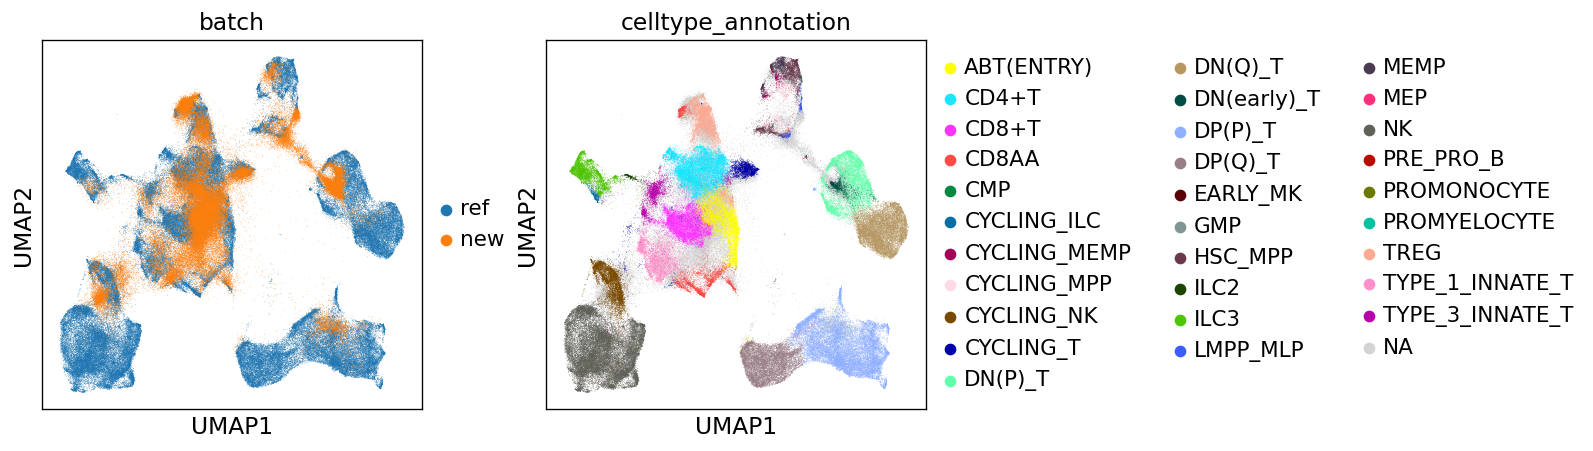

In [61]:
sc.pl.umap(adata_concat, color=['batch', 'celltype_annotation'])

In [62]:
adata_concat

AnnData object with n_obs × n_vars = 254566 × 26767
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'ID', 'sample_id', 'donor_id', 'tumour_type', 'site', 'type', 'mad_prd', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'percent_mito', 'percent_ribo', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type', 'batch'
    var: 'gene_ids-new', 'n_cells-new', 'Keep-new', 'GeneID-ref', 'GeneName-ref', 'highly_variable-ref', 'means-ref', 'dispersions-ref', 'dispersions_norm-ref', 'scvi_model_var-ref'
    uns: 'batch_colors', 'celltype_annotation_colors'
    obsm: 'X_pca', 'X_umap'

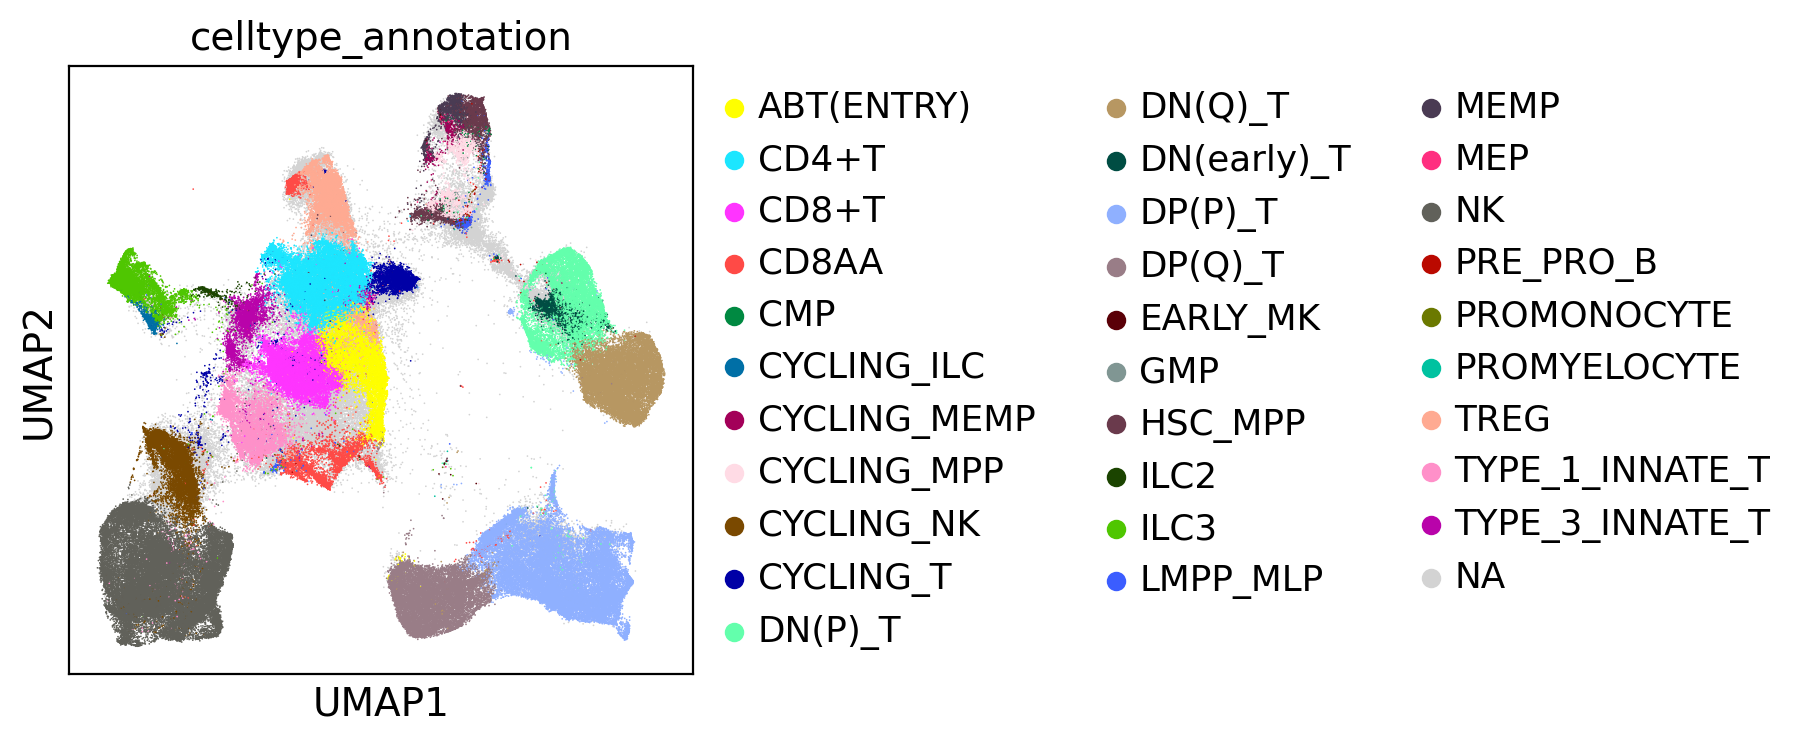

In [63]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_concat, color=['celltype_annotation'], size = 1.5)

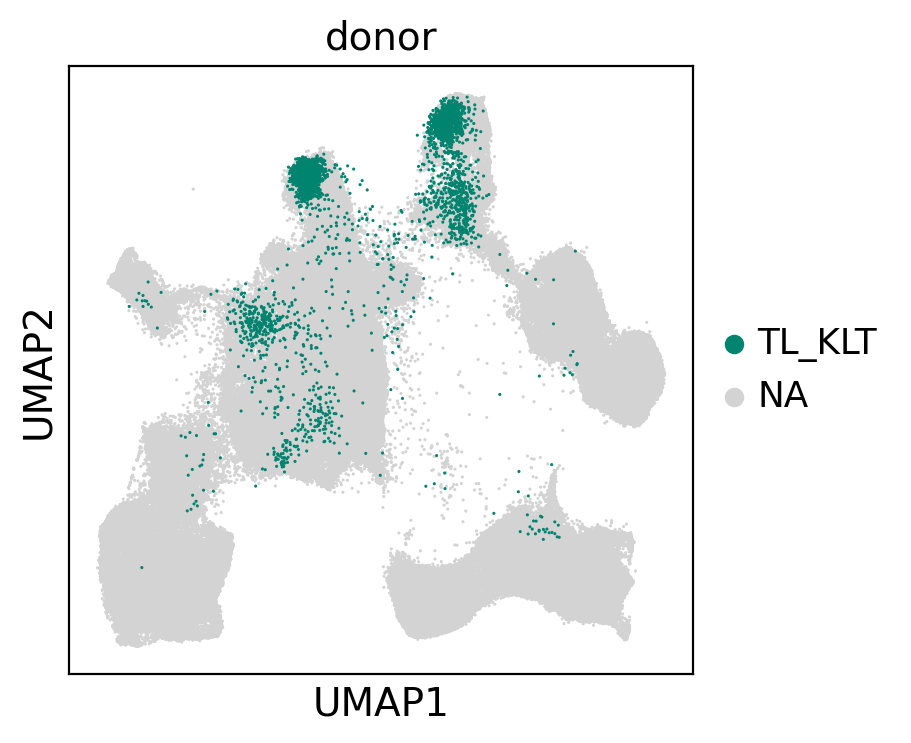

In [79]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_concat, color=['donor'],groups=['TL_KLT'],size=5)

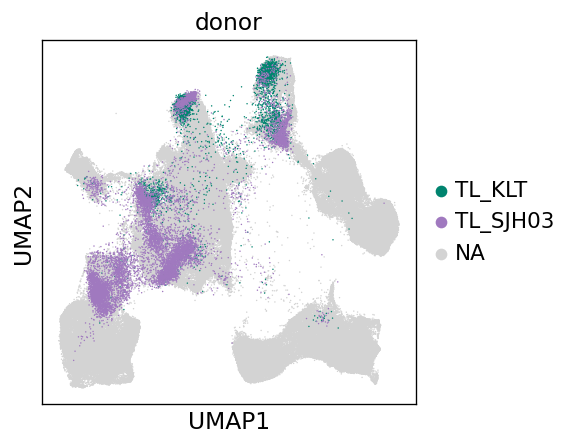

In [8]:
sc.settings.set_figure_params(dpi=60, facecolor='white')
sc.pl.umap(adata_concat, color=['donor'],groups=['TL_SJH03','TL_KLT'],size=3)

In [79]:
save_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Pan-fetal_TCL_ingest_new.h5ad'
adata_concat.write(save_file)

In [18]:
input_file = '/lustre/scratch126/cellgen/team205/rl20/T_cell_lym/object/Pan-fetal_TCL_ingest_new.h5ad'
adata_concat = sc.read_h5ad(input_file)

In [19]:
adata_concat

AnnData object with n_obs × n_vars = 254566 × 26899
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'method', 'donor', 'sex', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'ID', 'sample_id', 'donor_id', 'tumour_type', 'site', 'type', 'ds', 'mad_MED', 'mad_MAD', 'mad_thr', 'percent_mito', 'percent_ribo', 'leiden_0.8', 'leiden_1.0', 'leiden_1.0_c14', 'leiden_1.0_c14_C15', 'broad_cell_type', 'leiden_0.8_c22', 'leiden_0.8_c22_c3', 'malignant_call', 'malignant_call_donor', 'malignant_call_tumour_type', 'batch'
    var: 'gene_ids-new', 'n_cells-new', 'GeneID-ref', 'GeneName-ref', 'highly_variable-ref', 'means-ref', 'dispersions-ref', 'dispersions_norm-ref', 'scvi_model_var-ref'
    uns: 'batch_colors', 'celltype_annotation_colors', 'donor_colors', 'malignant_call_tumour_type_colors'
    obsm: 'X_pca', 'X_umap'

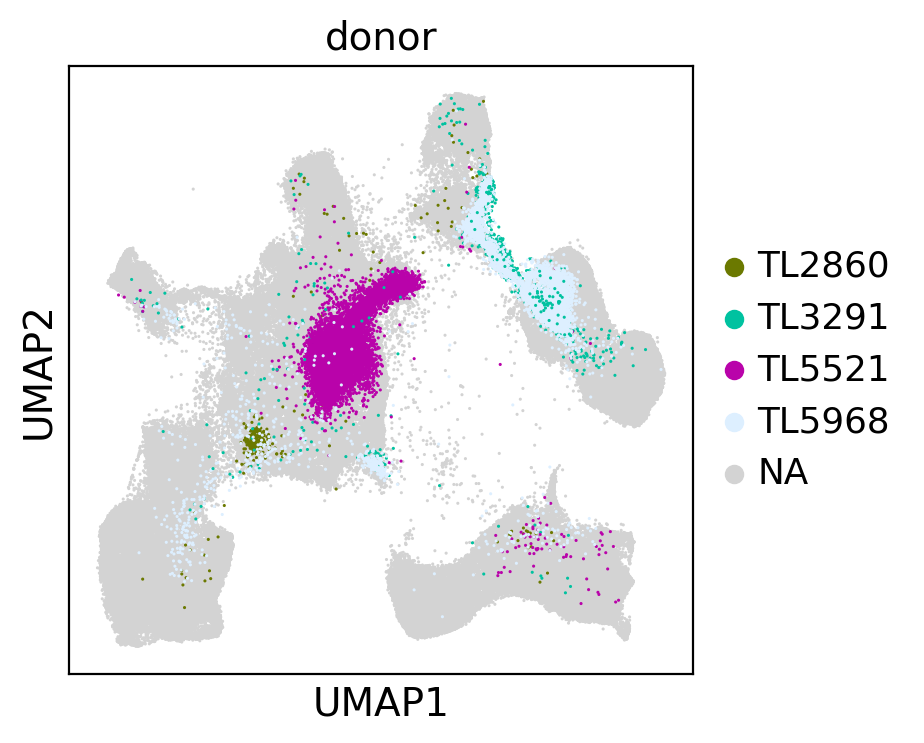

In [23]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_concat, color=['donor'],groups=['TL5521','TL3291','TL5968','TL2860'],size=5)